C:\Users\mhfar\AppData\Local\Temp\ipykernel_21016\2494077358.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


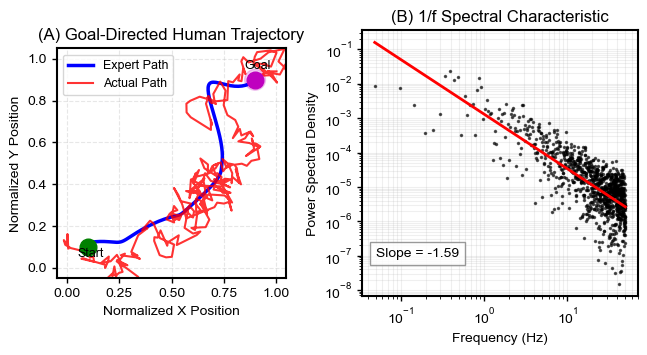

1/f noise with spectral slope: -1.59
Mean noise amplitude: 0.0818
Standard deviation: 0.0978


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

# Set publication-quality styling
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 10,
    'axes.linewidth': 1.5,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'mathtext.default': 'regular'
})

# Generate realistic human trajectory with sharp turn near the end
def generate_realistic_trajectory(n_points=300):
    # Define start and goal points
    start = (0.1, 0.1)
    goal = (0.9, 0.9)
    
    # Parameter for trajectory
    t = np.linspace(0, 1, n_points)
    
    # Create base path with general curvature
    x_direct = start[0] + (goal[0] - start[0]) * t
    y_direct = start[1] + (goal[1] - start[1]) * t
    
    # Add base curve to the path
    curve_factor = 0.15 * np.sin(np.pi * t)
    x = x_direct + curve_factor
    y = y_direct - curve_factor
    
    # Add fine curvature details
    x += 0.02 * np.sin(8 * np.pi * t)
    y += 0.02 * np.cos(7 * np.pi * t)
    
    # Add sharp turn near the end (as if avoiding an invisible obstacle)
    # Define where the sharp turn should occur (around 75-85% of the way)
    turn_center = 0.82
    turn_width = 0.08
    
    # Create a sharp deflection
    sharp_turn = 0.18 * np.exp(-((t - turn_center)/turn_width)**2)
    
    # Direction of the turn (perpendicular to the path)
    # We want it to appear as if avoiding something just before reaching the goal
    x -= sharp_turn  # Move left to avoid something
    y += sharp_turn  # Move up slightly to maintain smooth approach to goal
    
    # Ensure the path still reaches the goal
    # Adjust the final portion to smoothly connect to the goal
    final_approach = np.exp(-((t - 0.95)/0.05)**2)
    x = x * (1 - final_approach) + goal[0] * final_approach
    y = y * (1 - final_approach) + goal[1] * final_approach
    
    return x, y, start, goal

# Generate 1/f noise using AR(1) filter
def generate_pink_noise(n_samples, alpha=0.95, amplitude=0.035):
    white_noise = np.random.normal(0, amplitude, n_samples+100)
    pink_noise = np.zeros(n_samples+100)
    for i in range(1, len(pink_noise)):
        pink_noise[i] = white_noise[i] + alpha * pink_noise[i-1]
    pink_noise = pink_noise[100:]
    return pink_noise

# Create figure
fig = plt.figure(figsize=(7.5, 3.8))
gs = GridSpec(1, 2, width_ratios=[1, 1.2], wspace=0.3)

# Panel A: Trajectory with noise
ax1 = fig.add_subplot(gs[0])
n_points = 300
x, y, start, goal = generate_realistic_trajectory(n_points)

# Generate noise for x and y
np.random.seed(42)
noise_x = generate_pink_noise(n_points, alpha=0.95, amplitude=0.035)
noise_y = generate_pink_noise(n_points, alpha=0.95, amplitude=0.035)

# Add noise to trajectory
x_noisy = x + noise_x
y_noisy = y + noise_y

# Plot trajectories
ax1.plot(x, y, 'b-', linewidth=2.5, label='Expert Path')
ax1.plot(x_noisy, y_noisy, 'r-', linewidth=1.5, alpha=0.8, label='Actual Path')

# Add start and goal markers (but don't include in legend)
ax1.plot(start[0], start[1], 'go', markersize=12)
ax1.plot(goal[0], goal[1], 'mo', markersize=12)

# Draw a circle around the goal to represent target radius
goal_circle = patches.Circle(goal, 0.05, color='m', alpha=0.2)
ax1.add_patch(goal_circle)

# Add labels for start and goal
ax1.text(start[0]-0.05, start[1]-0.05, 'Start', fontsize=9)
ax1.text(goal[0]-0.05, goal[1]+0.05, 'Goal', fontsize=9)

ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.05, 1.05)
ax1.set_xlabel('Normalized X Position')
ax1.set_ylabel('Normalized Y Position')
ax1.set_title('(A) Goal-Directed Human Trajectory')
ax1.legend(frameon=True, fontsize=9, loc='upper left')
ax1.set_aspect('equal')
ax1.grid(True, linestyle='--', alpha=0.3)

# Panel B: Power spectral density with fit
ax2 = fig.add_subplot(gs[1])

# Generate longer noise sequence for better spectral estimate
fs = 100  # Hz
T = 30    # seconds
n = fs * T
long_noise = generate_pink_noise(n, alpha=0.95, amplitude=0.035)

# Calculate power spectral density
f, Pxx = signal.welch(long_noise, fs=fs, nperseg=2048, scaling='density')

# Remove DC and very low frequencies for better fitting
f = f[1:]
Pxx = Pxx[1:]

# Log transform for fitting
log_f = np.log10(f)
log_Pxx = np.log10(Pxx)

# Fit line to log-log data
coef = np.polyfit(log_f, log_Pxx, 1)
fit_line = np.poly1d(coef)

# Plot PSD and fit
ax2.loglog(f, Pxx, 'k.', markersize=3, alpha=0.6)
ax2.loglog(f, 10**fit_line(log_f), 'r-', linewidth=2)

# Add text annotation for slope
ax2.text(0.05, 0.15, f'Slope = {coef[0]:.2f}', transform=ax2.transAxes, 
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Power Spectral Density')
ax2.set_title('(B) 1/f Spectral Characteristic')
ax2.grid(True, which="both", ls="-", alpha=0.2)


# Add noise statistics as a text box in the main figure
noise_stats = (f"1/f Noise Parameters:\n"
               f"Spectral slope = {coef[0]:.2f}\n"
               f"Mean amplitude = {np.mean(np.abs(noise_y)):.3f}\n"
               f"Standard deviation = {np.std(noise_y):.3f}")

#fig.text(0.5, 0.01, noise_stats, ha='center', fontsize=9, 
         #bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray'))

plt.tight_layout()
plt.subplots_adjust(bottom=0.18)  # Make room for the text box
plt.savefig('human_motor_control_noise', dpi=300, bbox_inches='tight')
plt.show()

print(f"1/f noise with spectral slope: {coef[0]:.2f}")
print(f"Mean noise amplitude: {np.mean(np.abs(noise_y)):.4f}")
print(f"Standard deviation: {np.std(noise_y):.4f}")